In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
# Parameters
num_parts = 10     # Number of parts
num_time_slots = 12  

demand = {p: 10 for p in range(1, num_parts + 1)}  

amount_we_can_paint = {
                       1: 10,
                       2: 10,
                       3: 10,
                       4: 5,
                       5: 10,
                       6: 10,
                       7: 5,
                       8: 10,
                        9: 10,
                        10: 10
                       }  

parts_colors = {
    1: 'Red',
    2: 'Blue',
    3: 'Green',
    4: 'Yellow',
    5: 'Black',
    6: 'Red',
    7: 'Blue',
    8: 'Green',
    9: 'Yellow',
    10: 'Black'
}

color_cost = {
    'Red': 10,
    'Blue': 10,
    'Green': 10,
    'Yellow': 10,
    'Black': 10
}

In [3]:
model = gp.Model("PaintingProcessOptimization")

Restricted license - for non-production use only - expires 2025-11-24


In [4]:
# Define decision variables (binary)
produce_part_in_slot = model.addVars(
    range(1, num_parts + 1), range(num_time_slots),
    vtype=GRB.BINARY, name="produce_part_in_slot"
)

color_change = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), range(num_time_slots - 1), 
                              vtype=GRB.BINARY, name="color_change") 


In [5]:
model.setObjective(
    quicksum(color_change[p, p_prime, t] * color_cost[parts_colors[p]] 
              for p in range(1, num_parts + 1) 
              for p_prime in range(1, num_parts + 1) 
              for t in range(num_time_slots - 1) if p != p_prime),
    GRB.MINIMIZE
)

In [6]:
for t in range(num_time_slots - 1):  # Loop through time slots
    for p in range(1, num_parts + 1):  # Current part
        for p_prime in range(1, num_parts + 1):  # Next part
            
            if parts_colors[p] != parts_colors[p_prime]:  # Different parts
                
                model.addConstr(
                    color_change[p, p_prime, t] >= produce_part_in_slot[p, t] + produce_part_in_slot[p_prime, t + 1] - 1,
                    name=f"color_change_min_{p}_{p_prime}_{t}"
                )
                
                model.addConstr(
                    color_change[p, p_prime, t] <= produce_part_in_slot[p, t] + produce_part_in_slot[p_prime, t + 1],
                    name=f"color_change_max_{p}_{p_prime}_{t}"
                )

In [7]:
# Demand Fulfillment Constraints
for p in range(1, num_parts + 1):
    model.addConstr(
        gp.quicksum(produce_part_in_slot[p, t] * amount_we_can_paint[p] for t in range(num_time_slots)) >= demand[p],
        f"Demand_Fulfillment_{p}"
    )

# One Part Per Time Slot Constraint
for t in range(num_time_slots):
    model.addConstr(
        gp.quicksum(produce_part_in_slot[p, t] for p in range(1, num_parts + 1)) <= 1,
        f"One_Part_Per_Time_Slot_{t}"
    )

In [8]:
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1782 rows, 1220 columns and 5520 nonzeros
Model fingerprint: 0x3bdd3b24
Variable types: 0 continuous, 1220 integer (1220 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 60.0000000
Presolve removed 880 rows and 220 columns
Presolve time: 0.00s
Presolved: 902 rows, 1000 columns, 2880 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 0.000000e+00, 138 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   34   60.00000    0.

In [9]:
# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    
    # Print the constraints that are part of the IIS
    print("\nThe following constraints are part of the IIS:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(f"{c.constrName}")

Optimal solution found:
Objective function value (minimized cost): 40.0


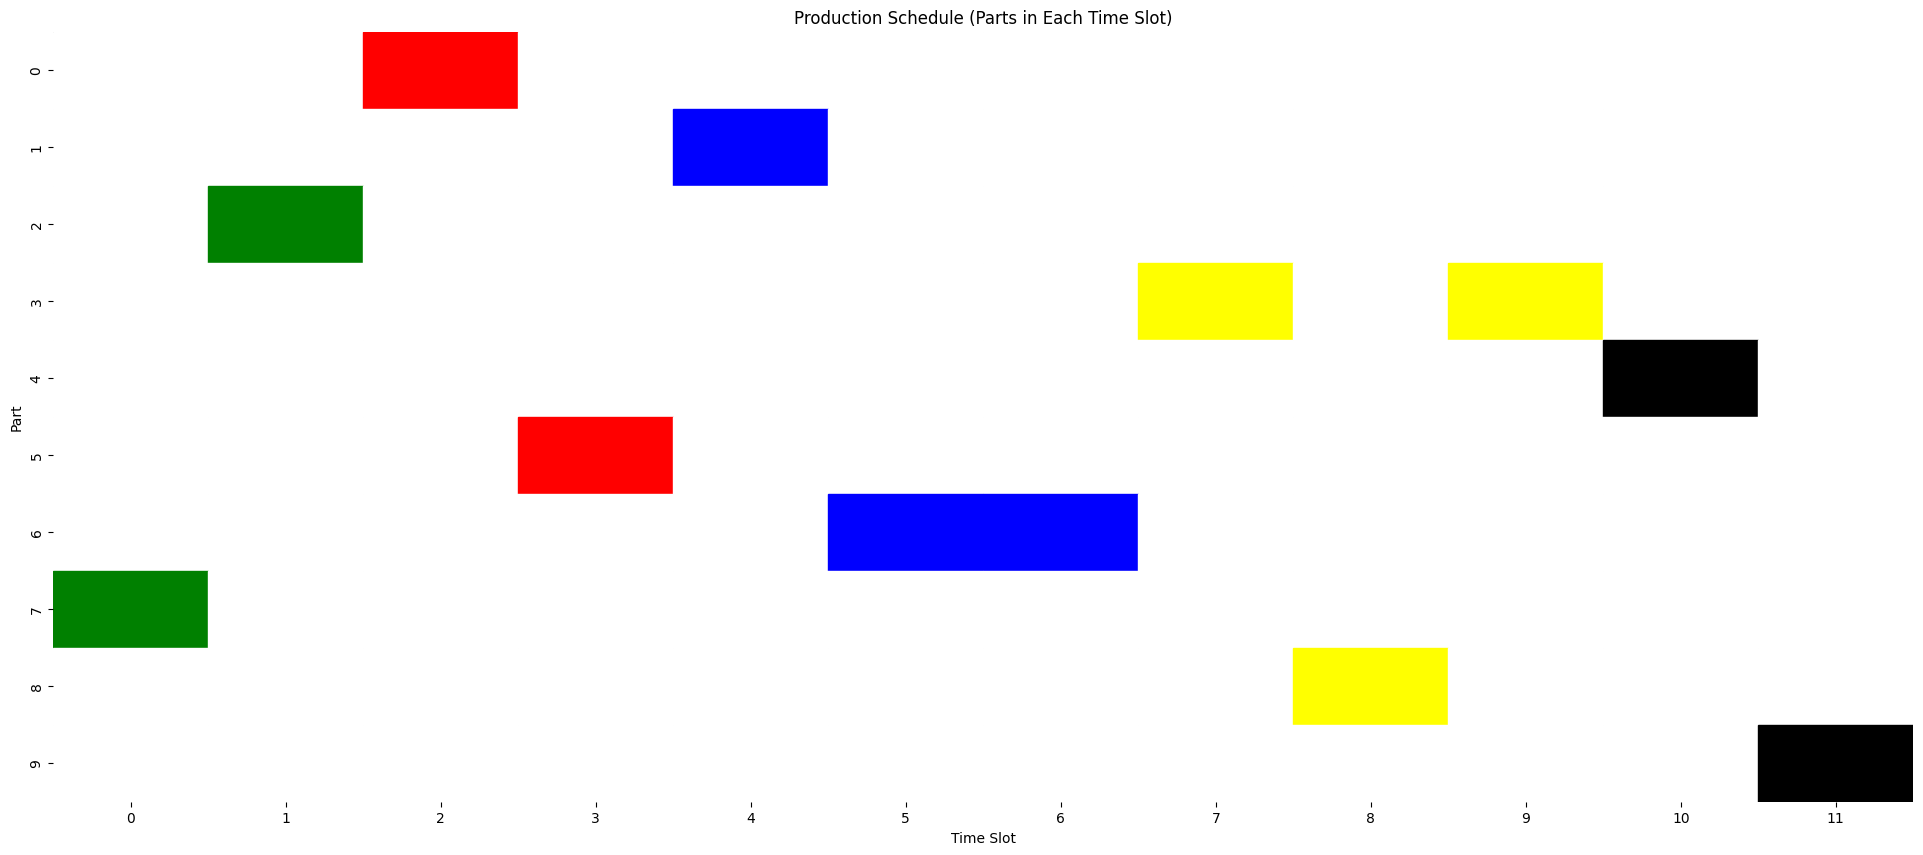

Minimized Total Cost (Objective Value): 40.0


In [10]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    
    # Extract time slot assignments
    part_schedule = np.zeros((num_parts, num_time_slots))  # Matrix to store part-time slot assignments
    color_matrix = np.empty((num_parts, num_time_slots), dtype=object)  # Matrix to store colors used

    for p in range(1, num_parts + 1):
        for t in range(num_time_slots):  # Using 0-based indexing for time slots
            if (p, t) in produce_part_in_slot:
                if produce_part_in_slot[p, t].X > 0.5:  # Only display if assigned
                    part_schedule[p - 1, t] = 1
                    # Assign the color based on the part's color
                    color_matrix[p - 1][t] = parts_colors[p]
                else:
                    color_matrix[p - 1][t] = 'White'  # No production assigned

    # Objective function value
    minimized_cost = model.ObjVal
    print("Objective function value (minimized cost):", minimized_cost)
    
    # Define color mapping for the heatmap
    color_map = {
        'Red': 'red',
        'Blue': 'blue',
        'Green': 'green',
        'Yellow': 'yellow',
        'Black': 'black',
        'White': 'white'  # For no production
    }

    # Create a matrix of colors for the heatmap
    color_values = np.array([[color_map[color] for color in row] for row in color_matrix])

    # Plot 1: Production Schedule Heatmap
    plt.figure(figsize=(24, 10))
    # Plot part schedule heatmap with custom colors
    sns.heatmap(part_schedule, cmap=ListedColormap(['white', 'blue']), cbar=False, 
                linewidths=0.1, linecolor='black', annot=False)  # Hide annotations
    # Overlay colors on the heatmap
    for (i, j), color in np.ndenumerate(color_values):
        plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color=color))

    plt.title("Production Schedule (Parts in Each Time Slot)")
    plt.xlabel("Time Slot")
    plt.ylabel("Part")
    plt.xlim(0, num_time_slots)  # Ensure the x-axis is correctly set
    plt.ylim(0, num_parts)  # Ensure the y-axis is correctly set
    plt.gca().invert_yaxis()  # Invert y-axis to have part 1 at the top
    plt.show()
    
    # Display objective function result
    print(f"Minimized Total Cost (Objective Value): {minimized_cost}")

else:
    print("No optimal solution found.")